In [1]:
import torch

torch.set_printoptions(precision=2, sci_mode=False)


def left_neighbors(sides,  size):
    neighbors = ['left', 'right', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]
    return [
        l[:, -size:, :],
        r[:, :size, :],
        t[-size:, :, :],
        d[:size, :, :],
    ]
    
def get_neighbors(sides,  side_name, size):    
    pad_map = {    
        'front': ['left', 'right', 'top', 'down'],        
        'right': ['front', 'back', 'top', 'down'],
        'back': ['right', 'left', 'top', 'down'],
        'left': ['back', 'front', 'top', 'down'],
        'top': ['left', 'right', 'back', 'front'],
        'down': ['left', 'right', 'front', 'back'],
    }
    if side_name == 'left':
        return left_neighbors(sides,  size)
    l, r, t, d = [sides[n] for n in pad_map[side_name]]
    return [
        l[:, -size:, :],
        r[:, :size, :],
        t[-size:, :, :],
        d[:size, :, :],
    ]

def make_tris(size, device):
    tl = torch.triu(torch.ones(size, size)) - (torch.eye(size) * 0.5)
    dr = torch.tril(torch.ones(size, size)) - (torch.eye(size) * 0.5)    
    tl, dr = tl.to(device), dr.to(device)
    res = {
        'tl': tl,
        'lt': tl.t().clone(),        
        'tr': tl.t().flip(dims=(0,)).t(),
        'rt': tl.flip(dims=(0,)).t(),
        'dr': dr.t(),
        'rd': dr,
        'ld': dr.flip(dims=(0,)).t(),
        'dl': dr.t().flip(dims=(0,)).t(),        
    }
    for k in res:
        res[k]=  torch.ones_like(res[k])
    return res

# lt/tl tr/rt
# ld/dl dr/rd
def get_corners(size, l, r, t, d):
    tris = make_tris(size, l.device)
    lt = l[-size:, :, :] * tris['lt']
    tl = t[:, -size:, :] * tris['tl']
    
    tr = t[:, :size, :] * tris['tr']
    rt = r[-size:, :, :] * tris['rt']
    
    ld = l[:size, :, :] * tris['ld']
    dl = d[:, -size:, :] * tris['dl']
        
    rd = r[:size, :, :] * tris['rd']
    dr = d[:, :size, :] * tris['dr']
    
    ltc = lt + tl
    trc = tr + rt
    ldc = ld + dl
    drc = dr + rd
    return ltc, trc, ldc, drc  

def pad_side(sides, side_name, kernel_size):
    o = sides[side_name]
    size = (kernel_size - 1) // 2
    l, r, t, d = get_neighbors(sides, side_name, size)
    lt, tr, ld, dr = get_corners(size, l, r, t, d)

    top = torch.cat((lt, t, tr), dim=1)    
    middle = torch.cat((l, o, r), dim=1)
    down = torch.cat((ld, d, dr), dim=1)
    
    return torch.cat((top, middle, down), dim=0)  

In [2]:
import torch
from collections import (
    namedtuple,
    OrderedDict,
)
import trimesh
from src.cleansed_cube import (
    make_cube_faces,
    SourceCube,
    SimpleCube,
)

n, start, end = 7, -0.5, 0.5

device = torch.device('cuda')
d1, d2 = torch.meshgrid(
    torch.linspace(start, end, steps=n),
    torch.linspace(start, end, steps=n))
d1, d2 = d1.to(device), d2.to(device)

d3 = torch.full_like(d1, end) + 1 / n
sides =  OrderedDict({
    'front': torch.stack((+d3,  d1,  d2), dim=-1),
    'right': torch.stack(( d1, +d3,  d2), dim=-1),    
    'back' : torch.stack((-d3,  d1,  d2), dim=-1),         
    'left' : torch.stack(( d1, -d3,  d2), dim=-1),
    'top'  : torch.stack(( d1,  d2, +d3), dim=-1),
    'down' : torch.stack(( d1,  d2, -d3), dim=-1),
})
sides.keys()

odict_keys(['front', 'right', 'back', 'left', 'top', 'down'])

<IPython.core.display.Javascript object>


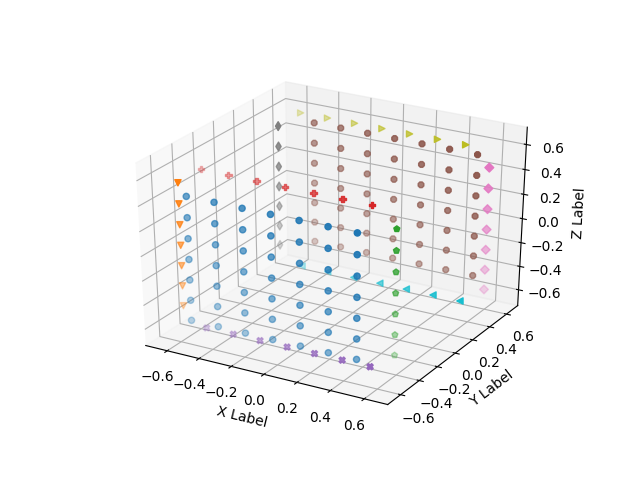

[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]


In [3]:
%matplotlib notebook

def left_neighbors(sides,  size):
    neighbors = ['back', 'front', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:size, :, :],
        r[:size, :, :],
        t[:, :size, :],
        d[:, :size, :],
    ]

def right_neighbors(sides,  size):
    neighbors = ['front', 'back', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[-size:, :, :],
        r[-size:, :, :],
        t[:, -size:, :],
        d[:, -size:, :],
    ]


#l, r, t, d = get_neighbors(sides, side_name, size)
#lt, tr, ld, dr = get_corners(size, l, r, t, d)

#top = torch.cat((lt, t, tr), dim=1)
#middle = torch.cat((l, o, r), dim=1)
#down = torch.cat((ld, d, dr), dim=1)


import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'
def plot(ax, t, m):
    t = t.cpu().numpy()
    xs = t[:, :, 0].flatten()
    ys = t[:, :, 1].flatten()
    zs = t[:, :, 2].flatten()
    print([x.shape for x in [xs, ys, zs]])
    ax.scatter(xs, ys, zs, marker=m)    

side_name, kernel_size = 'left', 3
o = sides[side_name]
size = (kernel_size - 1) // 2
l, r, t, d = left_neighbors(sides, size)

plot(ax, sides['left'], 'o')

plot(ax, l, 'v')
plot(ax, r, 'p')
plot(ax, t, 'P')
plot(ax, d, 'X') 

plot(ax, sides['right'], '8')
l, r, t, d = right_neighbors(sides, size)
plot(ax, l, 'D')
plot(ax, r, 'd')
plot(ax, t, '>')
plot(ax, d, '<')  

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


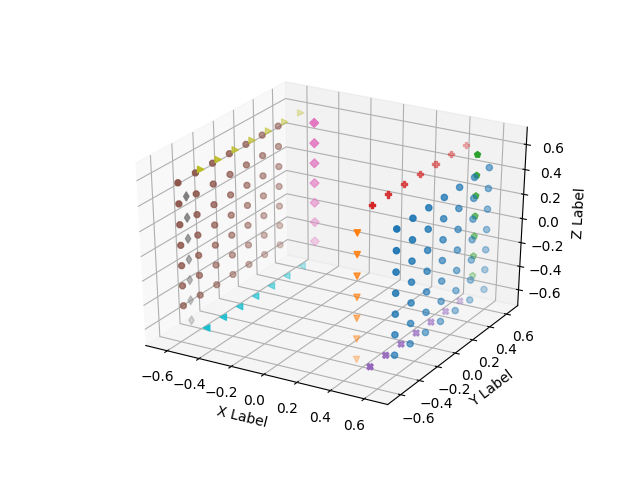

[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]


In [4]:
def front_neighbors(sides,  size):
    neighbors = ['left', 'right', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[-size:, :, :],
        r[-size:, :, :],
        t[-size:, :, :],
        d[-size:, :, :],
    ]

def back_neighbors(sides,  size):
    neighbors = ['right', 'left', 'top', 'down']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:size, :, :],
        r[:size, :, :],
        t[:size, :, :],
        d[:size, :, :],
    ]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'
def plot(ax, t, m):
    t = t.cpu().numpy()
    xs = t[:, :, 0].flatten()
    ys = t[:, :, 1].flatten()
    zs = t[:, :, 2].flatten()
    print([x.shape for x in [xs, ys, zs]])
    ax.scatter(xs, ys, zs, marker=m)    

side_name, kernel_size = 'front', 3
o = sides[side_name]
size = (kernel_size - 1) // 2
l, r, t, d = front_neighbors(sides, size)

plot(ax, sides['front'], 'o')

plot(ax, l, 'v')
plot(ax, r, 'p')
plot(ax, t, 'P')
plot(ax, d, 'X') 

plot(ax, sides['back'], '8')
l, r, t, d = back_neighbors(sides, size)
plot(ax, l, 'D')
plot(ax, r, 'd')
plot(ax, t, '>')
plot(ax, d, '<')  

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


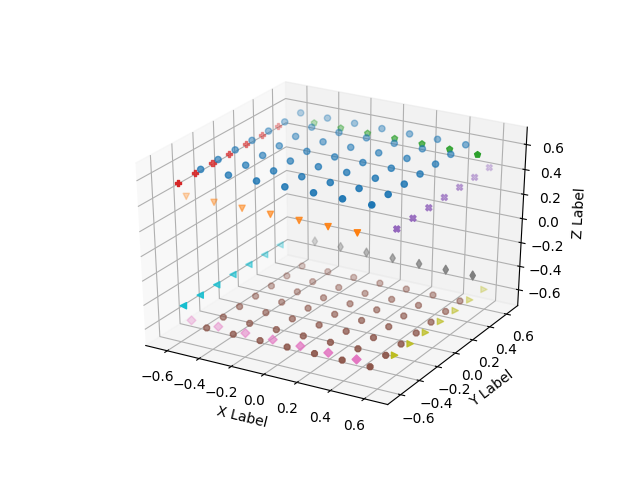

[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(49,), (49,), (49,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]
[(7,), (7,), (7,)]


In [5]:
def top_neighbors(sides,  size):
    neighbors = ['left', 'right', 'back', 'front']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:, -size:, :],
        r[:, -size:, :],
        t[:, -size:, :],
        d[:, -size:, :],
    ]

def down_neighbors(sides,  size):
    neighbors = ['left', 'right', 'front', 'back']
    l, r, t, d = [sides[n] for n in neighbors]    
    return [
        l[:, :size, :],
        r[:, :size, :],
        t[:, :size, :],
        d[:, :size, :],        
    ]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'
def plot(ax, t, m):
    t = t.cpu().numpy()
    xs = t[:, :, 0].flatten()
    ys = t[:, :, 1].flatten()
    zs = t[:, :, 2].flatten()
    print([x.shape for x in [xs, ys, zs]])
    ax.scatter(xs, ys, zs, marker=m)    

side_name, kernel_size = 'top', 3
o = sides[side_name]
size = (kernel_size - 1) // 2
l, r, t, d = top_neighbors(sides, size)

plot(ax, sides['top'], 'o')

plot(ax, l, 'v')
plot(ax, r, 'p')
plot(ax, t, 'P')
plot(ax, d, 'X') 

plot(ax, sides['down'], '8')
l, r, t, d = down_neighbors(sides, size)
plot(ax, l, 'D')
plot(ax, r, 'd')
plot(ax, t, '>')
plot(ax, d, '<')  

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()